#Import libraries and load functions

In [1]:
'''

This code is related to the paper :
[Identifying neuropathies through time series analyses of postural tests, 
Claudio Meneses V., Jorge Littin C., David Coo Aqueveque., Juan Guerrero-Henriquez, Martin Vargas M.] 

If you use this algorithm in your research work, please cite this paper.


'''

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import math

sns.set()

# Function to calculate Root Mean Square
def calculate_RMS(df):
  return  np.sqrt(np.mean(df **2)) 

# Function to calculate Velocity
def calculate_vel_global(x, y):
  vel_x = pd.DataFrame()
  vel_y = pd.DataFrame()
  vel_x = (pd.DataFrame.diff(x / 0.04))
  vel_y = (pd.DataFrame.diff(y / 0.04))
  return vel_x[1:], vel_y[1:]

# Function to calculate Acceleration
def calculate_acc_global(x, y):
  acc_x = pd.DataFrame()
  acc_y = pd.DataFrame()
  acc_x = pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04))
  acc_y = pd.DataFrame.diff(pd.DataFrame.diff(y / 0.04))
  return acc_x[2:], acc_y[2:]

# Function to calculate Jerk
def calculate_jerk_global(x, y):
  #a = np.empty((498,2))
  jerk_x = pd.DataFrame()
  jerk_y = pd.DataFrame()
  jerk_x = pd.DataFrame.diff(pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04)))
  jerk_y = pd.DataFrame.diff(pd.DataFrame.diff(pd.DataFrame.diff(y / 0.04)))
  return jerk_x[3:], jerk_y[3:]  


#Load txt files

In [5]:
# Set the path for the three folders in "COP_Examen"
# "DNG" for Diabetic Neuropathic Group,"DG" for Diabetic Group and "HG" for Healthy Group.
# Inside each folder you will find the files of:
# Eyes open on stable surface (EO).
# Eyes open on unstable surface (EOUS).
# Eyes open on stable surface with dual task (EODT).
# Eyes open on unstable surface with dual task (EOUSDT).
# Eyes closed on stable surface (EC).
# Eyes closed on unstable surface (ECUS).
# Eyes closed on stable surface with dual task (ECDT).
# Eyes closed on unstable surface with dual task (ECUSDT).

path_files = ['/COP_Tests/DNG/', '/COP_Tests/DG/', '/COP_Tests/HG/']
Test = ['EO','EOUS','EODT','EOUSDT','EC','ECUS','ECDT','ECUSDT']

def find_file(path_files):
    # This array allows to save the path of the found files.
    files = []
    for dirName, subdirList, fileList in os.walk(path_files):
          # Full directory and file name is added.
          files.append([os.path.join(dirName, f) for f in fileList  ])
    return files

found_files = []

val_x0, val_x1, val_x2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
val_y0, val_y1, val_y2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
class_attribute = pd.DataFrame(columns=['Exam','Class', 'Path'])
Exam = pd.DataFrame()
for value in enumerate(path_files):
  i = 0 
  print('Class:',value[0], value[1])
  
  for found_files in Test:
    found_files = find_file(value[1]+found_files)
    for batch in found_files:
      if(len(batch) != 0):
        print(batch)

        for archivo in range(len(batch)):
          print(':', batch[archivo])
          df_aux = pd.read_csv(str(batch[archivo]), sep=';', decimal=',', usecols=[1,2])
          print(i)
          if(value[0] == 0):    
    
            val_x0.insert(i, i, df_aux['x'])
            val_y0.insert(i, i, df_aux['y'])
            class_attribute.loc[len(class_attribute)] = [found_files, 'Healthy', batch[value]]
          if(value[0] == 1):
            
            val_x1.insert(i, i, df_aux['x'])
            val_y1.insert(i, i, df_aux['y'])
            class_attribute.loc[len(class_attribute)] = [found_files, 'Diabetic', batch[value]]
          if(value[0] == 2):
            
            val_x2.insert(i, i, df_aux['x'])
            val_y2.insert(i, i, df_aux['y'])
            class_attribute.loc[len(class_attribute)] = [found_files, 'Neuropathic', batch[value]]
          i += 1
    #break

Class: 0 /COP_Tests/DNG/
Class: 1 /COP_Tests/DG/
Class: 2 /COP_Tests/HG/


# Calculate Derivatives

In [ ]:
# Calculate Acceleration
acc_x0, acc_y0 = calculate_acc_global(val_x0, val_y0)
acc_x1, acc_y1 = calculate_acc_global(val_x1, val_y1)
acc_x2, acc_y2 = calculate_acc_global(val_x2, val_y2)
# Calculate Jerk
j_x0, j_y0 = calculate_jerk_global(val_x0, val_y0)
j_x1, j_y1 = calculate_jerk_global(val_x1, val_y1)
j_x2, j_y2 = calculate_jerk_global(val_x2, val_y2)

# Calculate Velocity (optional)
vel_x0, vel_y0 = calculate_vel_global(val_x0, val_y0)
vel_x1, vel_y1 = calculate_vel_global(val_x1, val_y1)
vel_x2, vel_y2 = calculate_vel_global(val_x2, val_y2)

# Show dimensions of arrays
print(val_x0.shape, val_x1.shape, val_x2.shape)
print(acc_x0.shape, acc_x1.shape, acc_x2.shape)

(500, 87) (500, 145) (500, 201)
(498, 87) (498, 145) (498, 201)


# Calculate Average Curve using RMS

In [ ]:
# Calculate Avergae Curve using RMS over dataframe.

umb_val0, umb_val1, umb_val2 = pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y'])
umb_acc0, umb_acc1, umb_acc2 = pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y'])
umb_j0, umb_j1, umb_j2 = pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y']), pd.DataFrame(columns=['x','y'])

#Sanos

for col in range(len(val_x0)):
  umb_val0 = umb_val0.append({'x': calculate_RMS(val_x0.iloc[col,:]),
                              'y': calculate_RMS(val_y0.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x0)):
  umb_acc0 = umb_acc0.append({'x': calculate_RMS(acc_x0.iloc[col,:]),
                              'y': calculate_RMS(acc_y0.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x0)):
  umb_j0 = umb_j0.append({'x': calculate_RMS(j_x0.iloc[col,:]),
                          'y': calculate_RMS(j_y0.iloc[col,:])}, ignore_index=True)

#SNp
for col in range(len(val_x1)):
  umb_val1 = umb_val1.append({'x': calculate_RMS(val_x1.iloc[col,:]),
                              'y': calculate_RMS(val_y1.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x1)):
  umb_acc1 = umb_acc1.append({'x': calculate_RMS(acc_x1.iloc[col,:]),
                              'y': calculate_RMS(acc_y1.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x1)):
  umb_j1 = umb_j1.append({'x': calculate_RMS(j_x1.iloc[col,:]),
                          'y': calculate_RMS(j_y1.iloc[col,:])}, ignore_index=True)

#Np
for col in range(len(val_x2)):
  umb_val2 = umb_val2.append({'x': calculate_RMS(val_x2.iloc[col,:]),
                              'y': calculate_RMS(val_y2.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x2)):
  umb_acc2 = umb_acc2.append({'x': calculate_RMS(acc_x2.iloc[col,:]),
                              'y': calculate_RMS(acc_y2.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x2)):
  umb_j2 = umb_j2.append({'x': calculate_RMS(j_x2.iloc[col,:]),
                          'y': calculate_RMS(j_y2.iloc[col,:])}, ignore_index=True)


# Concat Dataframe

In [ ]:
# Concat dataframes #
dataset, dataset1, dataset2, dataset3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

dataset1 = pd.concat([umb_val0, umb_acc0, umb_j0], axis=1, ignore_index=True)
dataset2 = pd.concat([umb_val1, umb_acc1, umb_j1], axis=1, ignore_index=True)
dataset3 = pd.concat([umb_val2, umb_acc2, umb_j2], axis=1, ignore_index=True)
dataset = pd.concat([dataset1,dataset2,dataset3], axis=0).reset_index(drop=True)
# Assign the three classes
dataset['Class'] = 'Healthy'
dataset['Class'][500:1000] = 'Diabetic'
dataset['Class'][1000:] = 'Neuropathic'
# Get the Test for each group (Otcional)
#dataset['Exam'] = class_attribute['Exam']

# Rename columns
dataset = dataset.rename(columns={0: "COP_x", 1: "COP_y", 2 : "Acc_x", 3 : "Acc_y", 4 : "Jerk_x", 5 : "Jerk_y"})

print(dataset.shape)
dataset.tail(8)

(1500, 7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,COP_x,COP_y,Acc_x,Acc_y,Jerk_x,Jerk_y,Class
0,0.681649,0.357277,0.433484,0.324126,0.457435,0.468179,Healthy
1,0.675154,0.351711,0.406740,0.281872,0.312508,0.282229,Healthy
2,0.670222,0.346279,0.422835,0.208643,0.255452,0.236001,Healthy
3,0.663639,0.341197,0.403644,0.199530,0.227061,0.229548,Healthy
4,0.657647,0.336719,0.388171,0.216358,0.278667,0.251536,Healthy
5,0.652480,0.333249,0.422975,0.219462,0.283472,0.247974,Healthy
6,0.649882,0.331537,0.424608,0.232754,0.290728,0.240842,Healthy
7,0.648676,0.330392,0.479105,0.257633,0.289164,0.249089,Healthy


# Plot Data

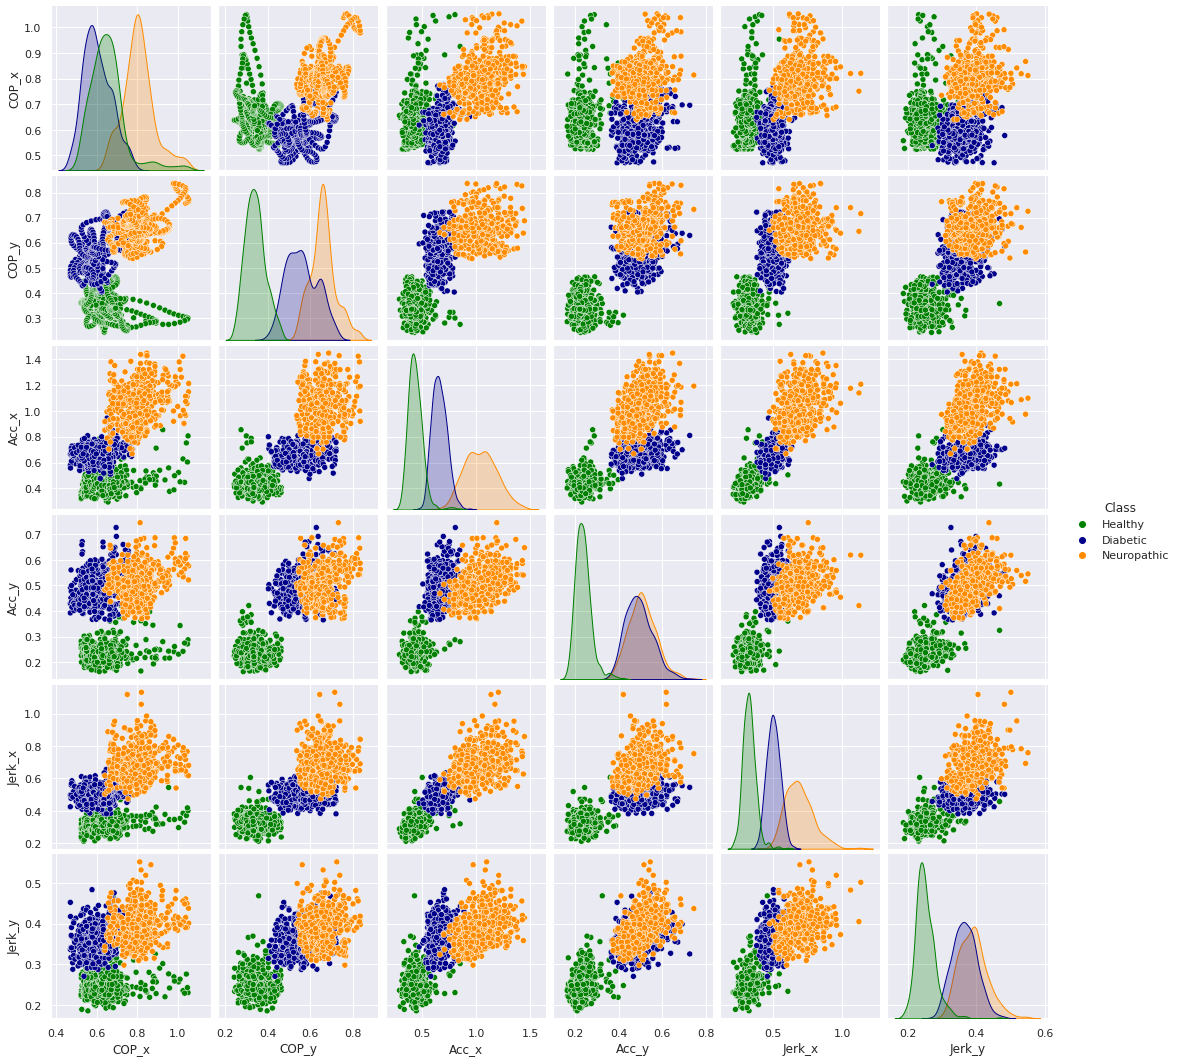

In [ ]:
# Plot RMS using Pairplot #
sns.pairplot(dataset, hue='Class',  palette={'Healthy' : 'green', 'Diabetic': 'darkblue', 'Neuropathic' : 'darkorange'})
plt.show()

# Pictures used in paper.

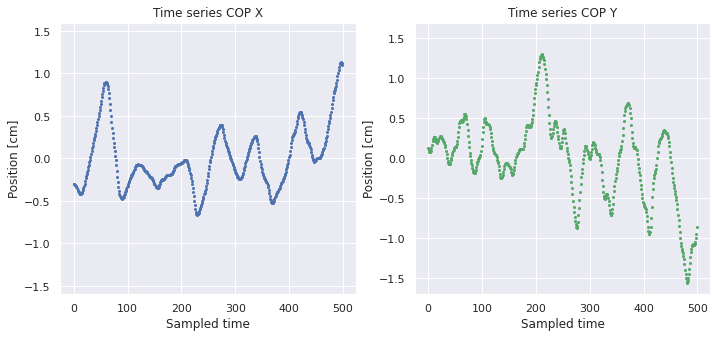

In [ ]:
#Figure 1

# Plot
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131)
ax1.set_title('Time series COP X')
ax1.set_xlabel('Sampled time')
ax1.set_ylabel('Position [cm]')
ax1.plot(val_x0.iloc[:,13], 'bo', markersize=2)
plt.ylim(-1.6,1.6)
ax2 = fig.add_subplot(132)
ax2.set_title('Time series COP Y')
ax2.set_xlabel('Sampled time')
ax2.set_ylabel('Position [cm]')
ax2.plot(val_y0.iloc[:,13], 'go',  markersize=2)
plt.ylim(-1.7,1.7)

plt.show()

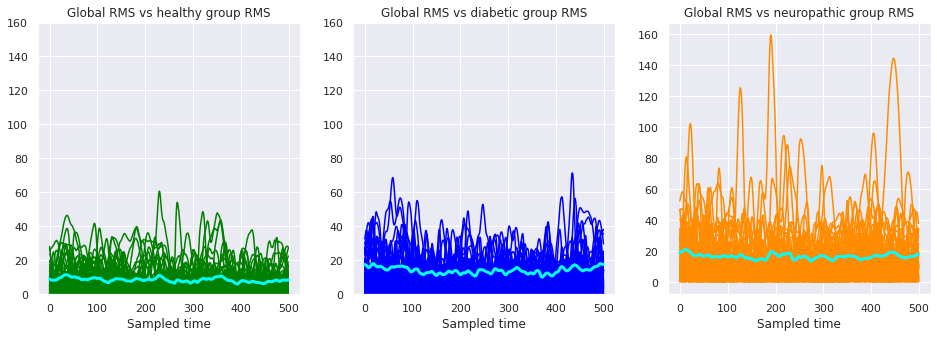

In [ ]:
#Figure 2
mean_curve0, mean_curve1, mean_curve2 = [], [], []
rms_val0, rms_val1, rms_val2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
# Global Curve RMS
for val in range(0, 500):
  mean_curve0.append(calculate_RMS(val_x0.iloc[val, :])/ 0.04) 
  mean_curve1.append(calculate_RMS(val_x1.iloc[val, :])/ 0.04) 
  mean_curve2.append(calculate_RMS(val_x2.iloc[val, :])/ 0.04) 
# RMS per patient
for val in val_x0:
  rms_val0.insert(val, val, np.sqrt(val_x0.iloc[:,val]**2) / 0.04)
  rms_val1.insert(val, val, np.sqrt(val_x1.iloc[:,val]**2) / 0.04)
  rms_val2.insert(val, val, np.sqrt(val_x2.iloc[:,val]**2) / 0.04)
# Plot
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax1.set_title('Global RMS vs healthy group RMS')
ax1.set_xlabel('Sampled time')
ax1.plot(rms_val0, color='green')
ax1.plot(mean_curve0, color='aqua', linewidth=3)
plt.ylim(0,160)
ax2 = fig.add_subplot(132)
ax2.set_title('Global RMS vs diabetic group RMS')
ax2.set_xlabel('Sampled time')
ax2.plot(rms_val1, color='blue')
ax2.plot(mean_curve1, color='aqua', linewidth=3)
plt.ylim(0,160)
ax3 = fig.add_subplot(133)
ax3.set_title('Global RMS vs neuropathic group RMS')
ax3.set_xlabel('Sampled time')
ax3.plot(rms_val2, color='darkorange')
ax3.plot(mean_curve2, color='aqua', linewidth=3)

plt.show()

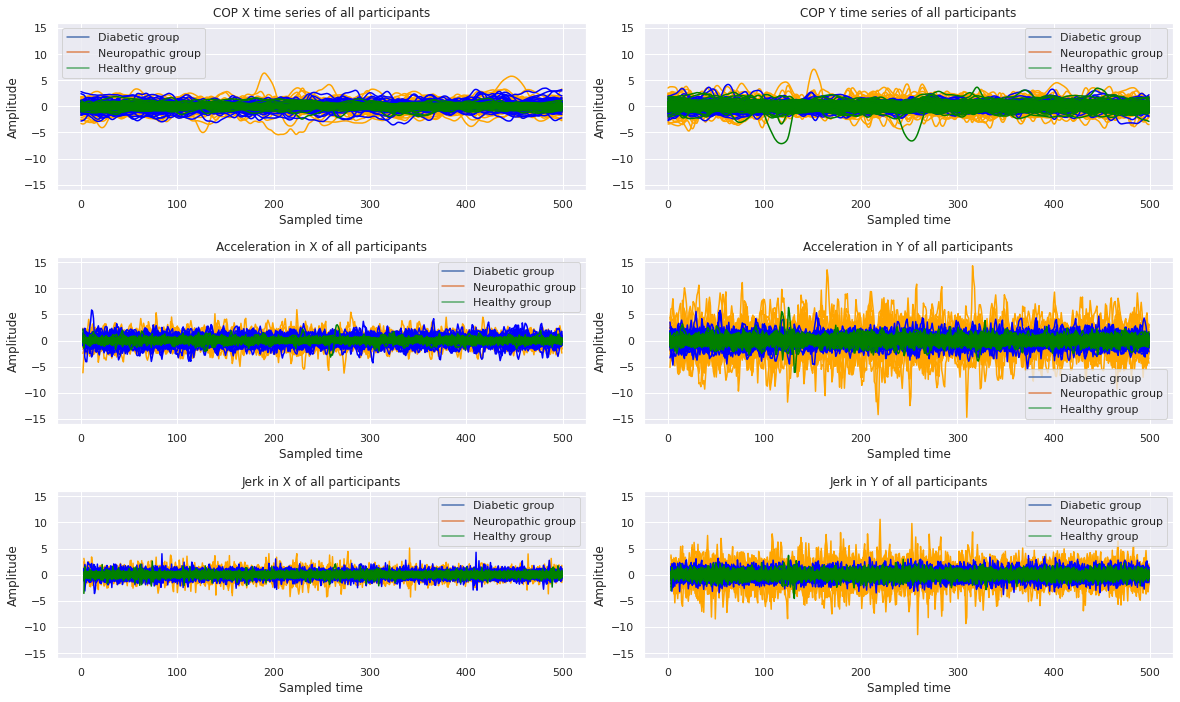

In [ ]:
#Figure 4
# Plot all time series per class.
fig = plt.figure(figsize=(20, 16))

ax1 = fig.add_subplot(421) 
plt.title('COP X time series of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax1.plot(val_x2, color='orange')
ax1.plot(val_x1, color='blue')
ax1.plot(val_x0, color='green')
line, = ax1.plot([1], label='Diabetic group')
line2, = ax1.plot([2], label='Neuropathic group')
line3, = ax1.plot([3], label='Healthy group')
ax1.legend()

ax2 = fig.add_subplot(422) 
plt.title('COP Y time series of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax2.plot(val_y2, color='orange')
ax2.plot(val_y1, color='blue')
ax2.plot(val_y0, color='green')
line, = ax2.plot([1], label='Diabetic group')
line2, = ax2.plot([2], label='Neuropathic group')
line3, = ax2.plot([3], label='Healthy group')
ax2.legend()

ax3 = fig.add_subplot(423) 
plt.title('Acceleration in X of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax3.plot(acc_x2, color='orange')
ax3.plot(acc_x1, color='blue')
ax3.plot(acc_x0, color='green')
line, = ax3.plot([1], label='Diabetic group')
line2, = ax3.plot([2], label='Neuropathic group')
line3, = ax3.plot([3], label='Healthy group')
ax3.legend()

ax4 = fig.add_subplot(424) 
plt.title('Acceleration in Y of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax4.plot(acc_y2, color='orange')
ax4.plot(acc_y1, color='blue')
ax4.plot(acc_y0, color='green')
line, = ax4.plot([1], label='Diabetic group')
line2, = ax4.plot([2], label='Neuropathic group')
line3, = ax4.plot([3], label='Healthy group')
ax4.legend()


ax5 = fig.add_subplot(425) 
plt.title('Jerk in X of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax5.plot(j_x2, color='orange')
ax5.plot(j_x1, color='blue')
ax5.plot(j_x0, color='green')
line, = ax5.plot([1], label='Diabetic group')
line2, = ax5.plot([2], label='Neuropathic group')
line3, = ax5.plot([3], label='Healthy group')
ax5.legend()

ax6 = fig.add_subplot(426) 
plt.title('Jerk in Y of all participants')
plt.ylim(-16,16)
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
ax6.plot(j_y2, color='orange')
ax6.plot(j_y1, color='blue')
ax6.plot(j_y0, color='green')
line, = ax6.plot([1], label='Diabetic group')
line2, = ax6.plot([2], label='Neuropathic group')
line3, = ax6.plot([3], label='Healthy group')
ax6.legend()


plt.subplots_adjust(hspace=0.4, wspace=0.11)
plt.show()


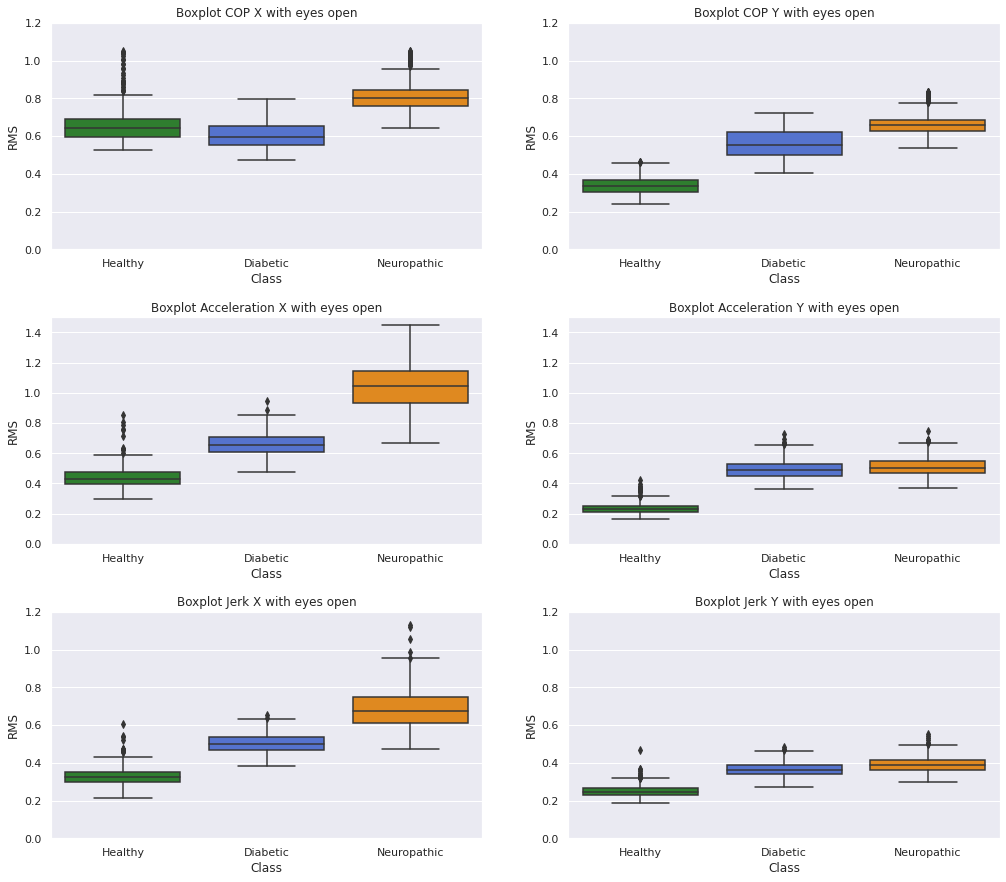

In [ ]:
#Figure 6
dataset_rms = pd.read_csv('Dataset_Curve_RMS_EO.csv', sep=';', decimal=',')
fig = plt.figure(figsize=(17, 15))

# COP
ax1 = fig.add_subplot(321)
plt.title('Boxplot COP X with eyes open')
sns.boxplot(x='Class', y='COP_x', data=dataset_rms, ax=ax1, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"}  )
plt.ylim(0,1.2)
plt.ylabel('RMS')
ax2 = fig.add_subplot(322)
plt.title('Boxplot COP Y with eyes open')
sns.boxplot(x='Class', y='COP_y',  data=dataset_rms, ax=ax2, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.2)
plt.ylabel('RMS')
ax3 = fig.add_subplot(323)
plt.title('Boxplot Acceleration X with eyes open')
sns.boxplot(x='Class', y='Acc_x', data=dataset_rms, ax=ax3, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.5)
plt.ylabel('RMS')
ax4 = fig.add_subplot(324)
plt.title('Boxplot Acceleration Y with eyes open')
sns.boxplot(x='Class', y='Acc_y',  data=dataset_rms, ax=ax4, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.5)
plt.ylabel('RMS')
ax5 = fig.add_subplot(325)
plt.title('Boxplot Jerk X with eyes open')
sns.boxplot(x='Class', y='Jerk_x', data=dataset_rms, ax=ax5, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.2)
plt.ylabel('RMS')
ax6 = fig.add_subplot(326)
plt.title('Boxplot Jerk Y with eyes open')
sns.boxplot(x='Class', y='Jerk_y',  data=dataset_rms, ax=ax6, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.2)
plt.ylabel('RMS')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

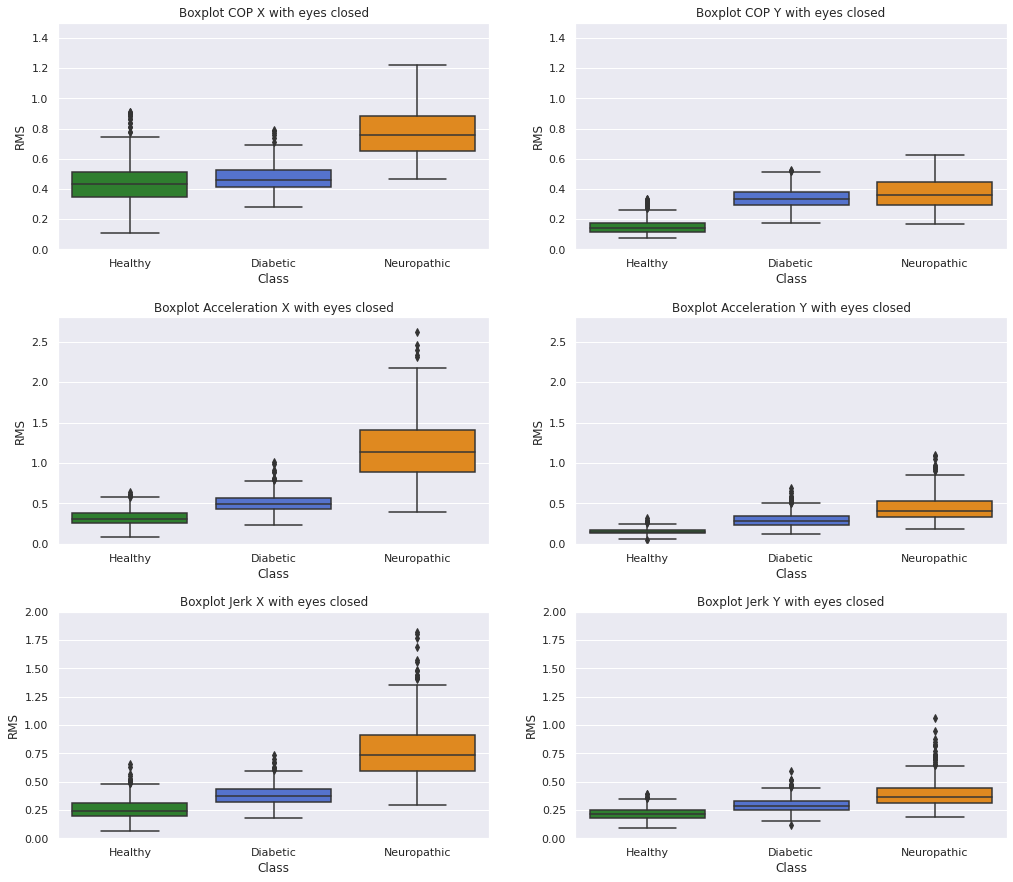

In [ ]:
#Figure 7
dataset_rms = pd.read_csv('Dataset_Curve_RMS_EC.csv', sep=';', decimal=',')
fig = plt.figure(figsize=(17, 15))

# COP
ax1 = fig.add_subplot(321)
plt.title('Boxplot COP X with eyes closed')
sns.boxplot(x='Class', y='COP_x', data=dataset_rms, ax=ax1, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"}  )
plt.ylim(0,1.5)
plt.ylabel('RMS')
ax2 = fig.add_subplot(322)
plt.title('Boxplot COP Y with eyes closed')
sns.boxplot(x='Class', y='COP_y',  data=dataset_rms, ax=ax2, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,1.5)
plt.ylabel('RMS')
ax3 = fig.add_subplot(323)
plt.title('Boxplot Acceleration X with eyes closed')
sns.boxplot(x='Class', y='Acc_x', data=dataset_rms, ax=ax3, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,2.8)
plt.ylabel('RMS')
ax4 = fig.add_subplot(324)
plt.title('Boxplot Acceleration Y with eyes closed')
sns.boxplot(x='Class', y='Acc_y',  data=dataset_rms, ax=ax4, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,2.8)
plt.ylabel('RMS')
ax5 = fig.add_subplot(325)
plt.title('Boxplot Jerk X with eyes closed')
sns.boxplot(x='Class', y='Jerk_x', data=dataset_rms, ax=ax5, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,2.0)
plt.ylabel('RMS')
ax6 = fig.add_subplot(326)
plt.title('Boxplot Jerk Y with eyes closed')
sns.boxplot(x='Class', y='Jerk_y',  data=dataset_rms, ax=ax6, palette={"Healthy": "forestgreen", "Diabetic" : "royalblue", "Neuropathic" : "darkorange"} )
plt.ylim(0,2.0)
plt.ylabel('RMS')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()